# Thermal modelling of a three winding transformer

In this example the following concepts are shown:
* Creating a ThreeWindingTransformer, and setting its parameters
* Creating a ThreeWindingInputProfile, that holds the profiles for a three winding transformer
* The the thermal modelling of a three winding transformer 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from transformer_thermal_model.cooler import CoolerType
from transformer_thermal_model.model import Model
from transformer_thermal_model.schemas import (
    ThreeWindingInputProfile,
    UserThreeWindingTransformerSpecifications,
    WindingSpecifications,
)
from transformer_thermal_model.transformer import ThreeWindingTransformer


The creation of a ThreeWindingInputProfile is similar to the creation of a normal InputProfile, except that the load_profile is now replaced with a seperate profile for the low, medium and high voltage side of the transformer. These profiles should all have the same length. 

In [39]:
# Define the time range for your simulation
datetime_index = [pd.to_datetime("2025-07-01 00:00:00") + pd.Timedelta(minutes=15 * i) for i in np.arange(0, 288)]

load_series_high = pd.Series(data=np.sin(np.arange(0, 288) * 900 * 2 * np.pi * 1 / 43200) * 500 + 500, index=datetime_index)
load_series_middle = pd.Series(data=np.sin(np.arange(0, 288) * 900 * 2 * np.pi * 1 / 43200) * 500 + 500, index=datetime_index)
load_series_low = pd.Series(data=np.sin(np.arange(0, 288) * 900 * 2 * np.pi * 1 / 43200) * 500 + 500, index=datetime_index)

ambient_series = pd.Series(data=20, index=datetime_index)

# Create the input profile for the three-winding transformer
profile_input = ThreeWindingInputProfile.create(
    datetime_index=datetime_index,
    ambient_temperature_profile=ambient_series,
    load_profile_high_voltage_side=load_series_high,
    load_profile_middle_voltage_side=load_series_middle,
    load_profile_low_voltage_side=load_series_low,
)


Next, we create an `ThreeWindingTransformer` object, this is a Child class of the Transformer object. To create this, a user needs to pass specifications in the `UserThreeWindingTransformerSpecifications` class, in this class the following inputs are mandatory:
* The no-load loss [W]
* The ambient temperature surcharge [K]
* Specifications of the low voltage winding, these are set with a `WindingSpecifications` containing:
    * the nominal load [A]
    * temperature difference between the average winding and average oil temperature under nominal conditions [K]
* mv_winding (again with a `WindingSpecifications` class)
* hv_winding (again with a `WindingSpecifications` class)
* The load loss between high-voltage and low-voltage winding [W]
* The load loss between high-voltage and middle-voltage winding [W]
* The load loss between middle-voltage and low-voltage winding [W]

Similar to `UserTransformerSpecifications`, you can also specify a lot off other optional parameters, if these are not set, the default values are used.

In [46]:

# Define the transformer specifications for each winding
user_specs = UserThreeWindingTransformerSpecifications(
    no_load_loss=20,
    amb_temp_surcharge=10,
    lv_winding=WindingSpecifications(nom_load=1000, winding_oil_gradient=20),
    mv_winding=WindingSpecifications(nom_load=1250, winding_oil_gradient=20),
    hv_winding=WindingSpecifications(nom_load=1500, winding_oil_gradient=20),
    load_loss_hv_lv=100,
    load_loss_hv_mv=100,
    load_loss_mv_lv=100,
)

# Create the transformer object
transformer = ThreeWindingTransformer(user_specs=user_specs, cooling_type=CoolerType.ONAN)

The specifications that are used in the thermal model can consulted in the `specs` property.

In [17]:
transformer.specs

ThreeWindingTransformerSpecifications(no_load_loss=20.0, amb_temp_surcharge=10.0, time_const_oil=210.0, time_const_windings=10.0, top_oil_temp_rise=60.0, winding_oil_gradient=17.0, hot_spot_fac=1.3, oil_const_k11=0.5, winding_const_k21=2, winding_const_k22=2, oil_exp_x=0.8, winding_exp_y=1.3, end_temp_reduction=0.0, lv_winding=WindingSpecifications(nom_load=1000.0, winding_oil_gradient=20.0), mv_winding=WindingSpecifications(nom_load=1500.0, winding_oil_gradient=20.0), hv_winding=WindingSpecifications(nom_load=1500.0, winding_oil_gradient=20.0), load_loss_hv_lv=100.0, load_loss_hv_mv=100.0, load_loss_mv_lv=100.0, load_loss_total=300.0)

Now we can create a model based on the transformer and the profiles and run the model to create a temperature profile of the top-oil and the hot-spot. This is exactly the same as for Power- and Distribution transformers.

In [49]:
model = Model(
    temperature_profile=profile_input,
    transformer=transformer
)
results = model.run()
top_oil_temp_profile = results.top_oil_temp_profile
hot_spot_temp_profile = results.hot_spot_temp_profile

A three winding transformers has three hotspot temperature profiles, one for each winding. The return profile of `results.hot_spot_temp_profile` is therefor a pandas Dataframe with 3 columns:

In [53]:
hot_spot_temp_profile

,low_voltage_side,middle_voltage_side,high_voltage_side
2025-07-01 00:00:00,30.000000,30.000000,30.000000
2025-07-01 00:15:00,42.702117,39.826334,38.023129
2025-07-01 00:30:00,50.449606,45.947893,43.125180
2025-07-01 00:45:00,55.852841,50.320500,46.851552
2025-07-01 01:00:00,60.106827,53.839210,49.909222
...,...,...,...
2025-07-03 22:45:00,37.188908,36.626920,36.274537
2025-07-03 23:00:00,38.976927,37.969513,37.337834
2025-07-03 23:15:00,41.061361,39.552582,38.606532
2025-07-03 23:30:00,43.427206,41.367898,40.076648


It only has one top oil temperature, so `results.top_oil_temp_profile` is still a pandas series

In [54]:
top_oil_temp_profile


2025-07-01 00:00:00    30.000000
2025-07-01 00:15:00    31.281271
2025-07-01 00:30:00    32.571563
2025-07-01 00:45:00    33.881775
2025-07-01 01:00:00    35.215700
                         ...    
2025-07-03 22:45:00    34.957037
2025-07-03 23:00:00    34.976100
2025-07-03 23:15:00    35.069419
2025-07-03 23:30:00    35.248897
2025-07-03 23:45:00    35.525543
Length: 288, dtype: float64

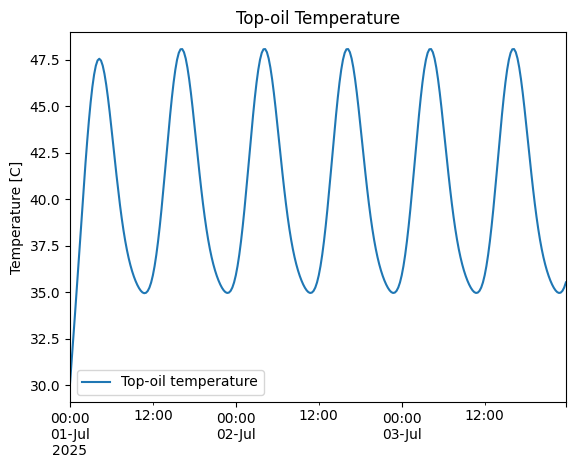

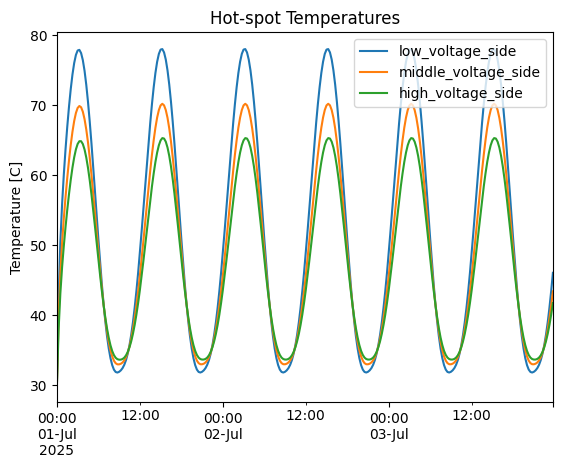

In [55]:
# Plot the top-oil temperature profile
fig1, ax1 = plt.subplots()
results.top_oil_temp_profile.plot(ax=ax1, label="Top-oil temperature")
ax1.set_title("Top-oil Temperature")
ax1.set_ylabel("Temperature [C]")
ax1.legend()
plt.show()

# Plot the hot-spot temperature profiles
fig2, ax2 = plt.subplots()
results.hot_spot_temp_profile.plot(ax=ax2)
ax2.set_title("Hot-spot Temperatures")
ax2.set_ylabel("Temperature [C]")
ax2.legend()
plt.show()